# Preparing Alpha Factors and Features to Predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2018-01-01'
END = '2022-12-31'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading YFinance Stock Prices & US Equities Meta Data

In [6]:
ohlcv = ['open', 'close', 'low', 'high', 'volume']

In [7]:
DATA_STORE = '../data/assets.h5'

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['stocks/yfinance/prices']
              .sort_index(level=0)
              .loc[idx[START:END, :], ohlcv]
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel())
    stocks = (store['stocks/quandl/metadata'])

In [9]:
prices

,,open,close,low,high,volume
ticker,date,,,,,
AAPL,2018-01-02,40.451276,40.950497,40.237322,40.960008,102223.600
AEG,2018-01-02,5.166960,5.158823,5.142549,5.175097,1449.200
AMZN,2018-01-02,58.599998,59.450500,58.525501,59.500000,53890.000
BA,2018-01-02,281.847655,282.886414,281.514101,283.029357,2978.900
BHP,2018-01-02,32.148108,32.677608,32.058713,32.684484,2971.883
...,...,...,...,...,...,...
SNY,2022-12-30,48.209999,48.430000,47.880001,48.570000,1302.700
T,2022-12-30,18.157801,18.147943,17.960648,18.216947,26200.800
TM,2022-12-30,136.880005,136.580002,136.000000,137.399994,168.700


## Remove stocks with few observations

In [10]:
# we want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26439 entries, ('AAPL', Timestamp('2018-01-02 00:00:00')) to ('WMT', Timestamp('2022-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    26439 non-null  float64
 1   close   26439 non-null  float64
 2   low     26439 non-null  float64
 3   high    26439 non-null  float64
 4   volume  26439 non-null  float64
dtypes: float64(5)
memory usage: 1.7+ MB


### Align price and meta data

In [11]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [12]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [13]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26439 entries, ('AAPL', Timestamp('2018-01-02 00:00:00')) to ('WMT', Timestamp('2022-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    26439 non-null  float64
 1   close   26439 non-null  float64
 2   low     26439 non-null  float64
 3   high    26439 non-null  float64
 4   volume  26439 non-null  float64
dtypes: float64(5)
memory usage: 1.7+ MB


In [14]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, AAPL to WMT
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       21 non-null     object 
 1   lastsale   21 non-null     float64
 2   marketcap  21 non-null     float64
 3   ipoyear    7 non-null      float64
 4   sector     21 non-null     object 
 5   industry   21 non-null     object 
dtypes: float64(3), object(3)
memory usage: 1.1+ KB


In [15]:
stocks.sector.value_counts()

technology               7
capital_goods            3
consumer_services        2
energy                   2
health_care              2
finance                  1
basic_industries         1
miscellaneous            1
consumer_non-durables    1
public_utilities         1
Name: sector, dtype: int64

Optional: persist intermediate results:

In [16]:
# with pd.HDFStore('tmp.h5') as store:
#     store.put('prices', prices)
#     store.put('stocks', stocks)

In [17]:
# with pd.HDFStore('tmp.h5') as store:
#     prices = store['prices']
#     stocks = store['stocks']

## Compute Rolling Average Dollar Volume

In [18]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [19]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21)
                           .mean()).values

In [20]:
prices.head()

open      close        low       high    volume  \
ticker date                                                               
AAPL   2018-01-02  40.451276  40.950497  40.237322  40.960008  102223.6   
       2018-01-03  41.014685  40.943367  40.879184  41.494891  118071.6   
       2018-01-04  41.017055  41.133541  40.907703  41.238141   89738.4   
       2018-01-05  41.231017  41.601868  41.138305  41.689825   94640.0   
       2018-01-08  41.447338  41.447338  41.347490  41.746870   82271.2   

                     dollar_vol  dollar_vol_1m  
ticker date                                     
AAPL   2018-01-02  4.186107e+06            NaN  
       2018-01-03  4.834249e+06            NaN  
       2018-01-04  3.691258e+06            NaN  
       2018-01-05  3.937201e+06            NaN  
       2018-01-08  3.409922e+06            NaN

In [21]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [22]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26439 entries, ('AAPL', Timestamp('2018-01-02 00:00:00')) to ('WMT', Timestamp('2022-12-30 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             26439 non-null  float64
 1   close            26439 non-null  float64
 2   low              26439 non-null  float64
 3   high             26439 non-null  float64
 4   volume           26439 non-null  float64
 5   dollar_vol       26439 non-null  float64
 6   dollar_vol_1m    26019 non-null  float64
 7   dollar_vol_rank  26019 non-null  float64
dtypes: float64(8)
memory usage: 2.3+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [23]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

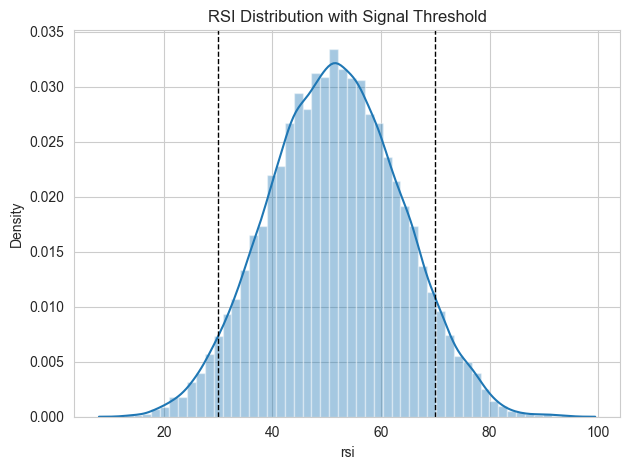

In [24]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [25]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [26]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [27]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

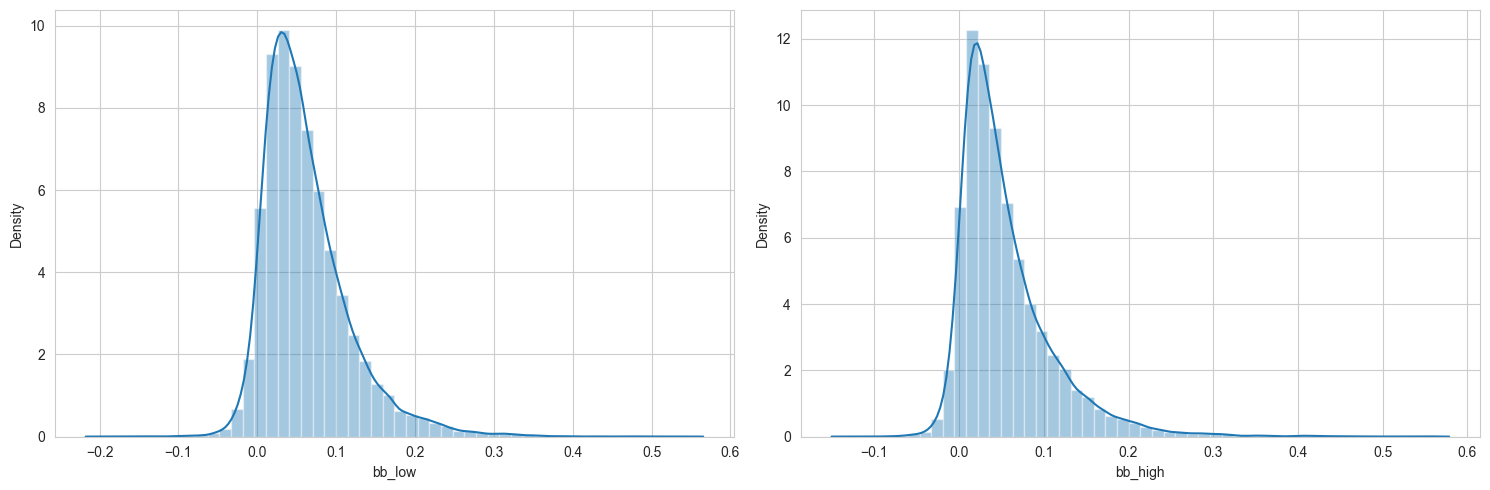

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [29]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [30]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

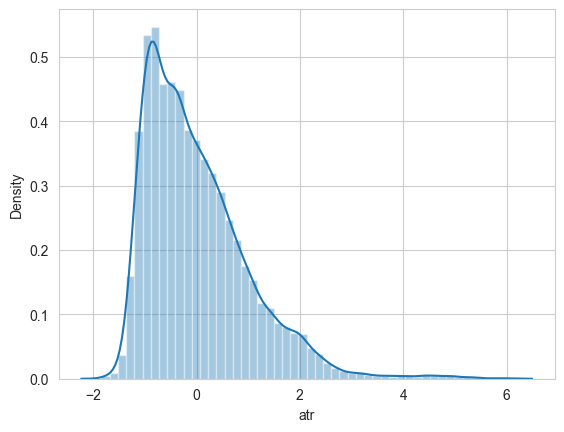

In [31]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [32]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [33]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [34]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    25,746.0
mean         -0.0
std           1.0
min          -6.8
0.1%         -4.6
1%           -2.9
2%           -2.4
3%           -2.1
4%           -1.9
5%           -1.7
50%           0.0
95%           1.5
96%           1.6
97%           1.8
98%           2.0
99%           2.3
99.9%         3.7
max           4.6
Name: macd, dtype: object

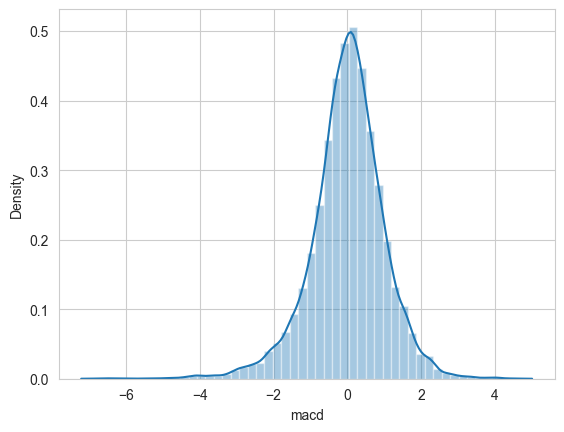

In [35]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [36]:
lags = [1, 5, 10, 21, 42, 63]

In [37]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,2.26%
min,-23.85%
0.01%,-19.84%
0.1%,-13.94%
1%,-6.19%
50%,0.05%
99%,6.44%
99.9%,12.69%
99.99%,20.28%
max,24.32%


In [38]:
q = 0.0001

### Winsorize outliers

In [39]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [40]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [41]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [42]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [43]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [44]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26439 entries, ('AAPL', Timestamp('2018-01-02 00:00:00')) to ('WMT', Timestamp('2022-12-30 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             26439 non-null  float64
 1   close            26439 non-null  float64
 2   low              26439 non-null  float64
 3   high             26439 non-null  float64
 4   volume           26439 non-null  float64
 5   dollar_vol       26439 non-null  float64
 6   dollar_vol_1m    26019 non-null  float64
 7   dollar_vol_rank  26019 non-null  float64
 8   rsi              26145 non-null  float64
 9   bb_high          26040 non-null  float64
 10  bb_low           26040 non-null  float64
 11  atr              26145 non-null  float64
 12  macd             25746 non-null  float64
 13  return_1d        26418 non-null  float64
 14  return_5d        26334 non-null  float64
 15  return_10d       26229 non-

In [45]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

In [46]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [47]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26439 entries, ('AAPL', Timestamp('2018-01-02 00:00:00')) to ('WMT', Timestamp('2022-12-30 00:00:00'))
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open                   26439 non-null  float64
 1   close                  26439 non-null  float64
 2   low                    26439 non-null  float64
 3   high                   26439 non-null  float64
 4   volume                 26439 non-null  float64
 5   dollar_vol             26439 non-null  float64
 6   dollar_vol_1m          26019 non-null  float64
 7   dollar_vol_rank        26019 non-null  float64
 8   rsi                    26145 non-null  float64
 9   bb_high                26040 non-null  float64
 10  bb_low                 26040 non-null  float64
 11  atr                    26145 non-null  float64
 12  macd                   25746 non-null  float64
 13  return_1d              26418 

## Store Model Data

In [48]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [49]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [50]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [51]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",963.0,0.000010,0.017658,-0.107584,-0.005213,0.001097,0.007088,0.089557
"(30, 70]",23313.0,0.000231,0.009467,-0.083638,-0.004407,0.000472,0.005233,0.087714
"(70, 100]",1638.0,0.000023,0.009289,-0.047261,-0.004525,0.000090,0.004548,0.044731


### Bollinger Bands

-0.85% (17.37%)


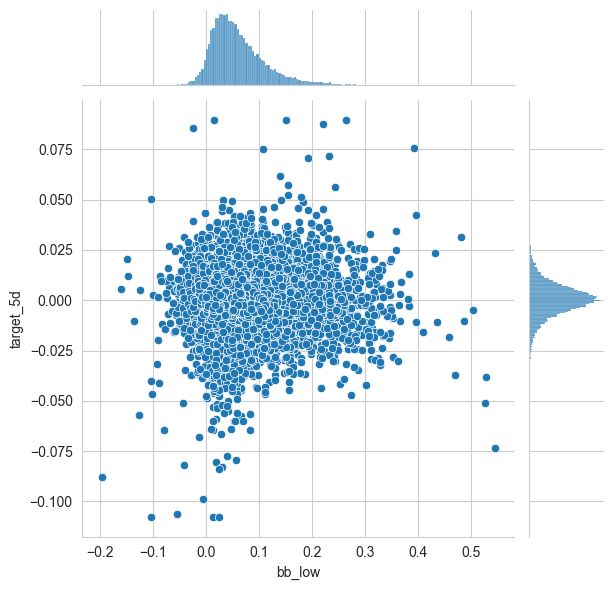

In [52]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

1.54% (1.33%)


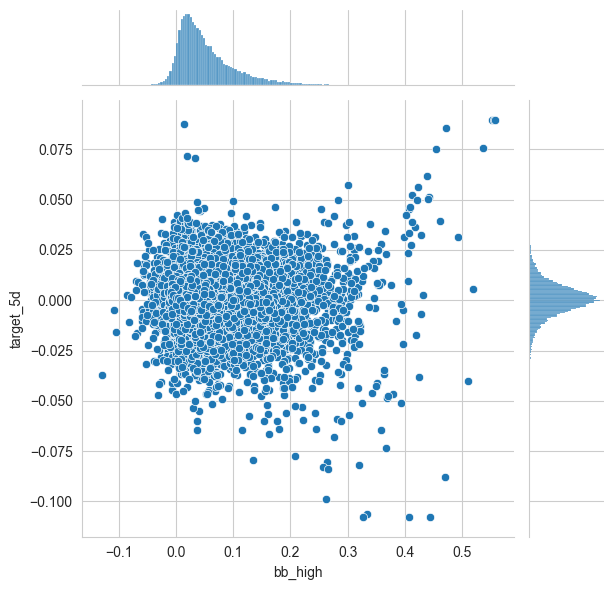

In [53]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

-1.63% (0.87%)


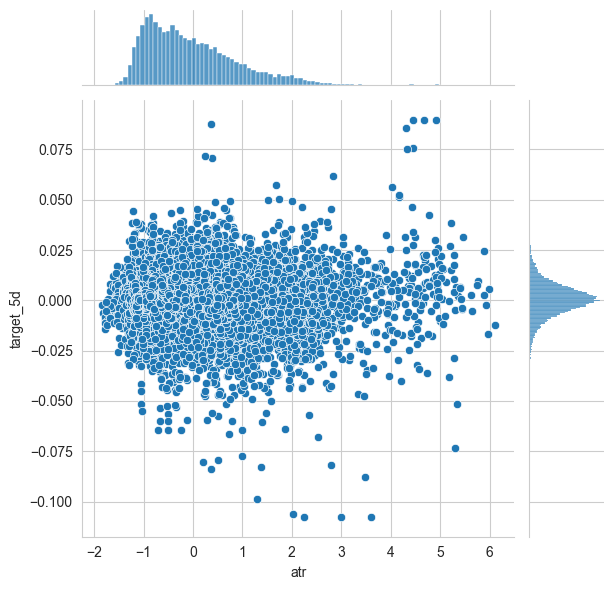

In [54]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-4.75% (0.00%)


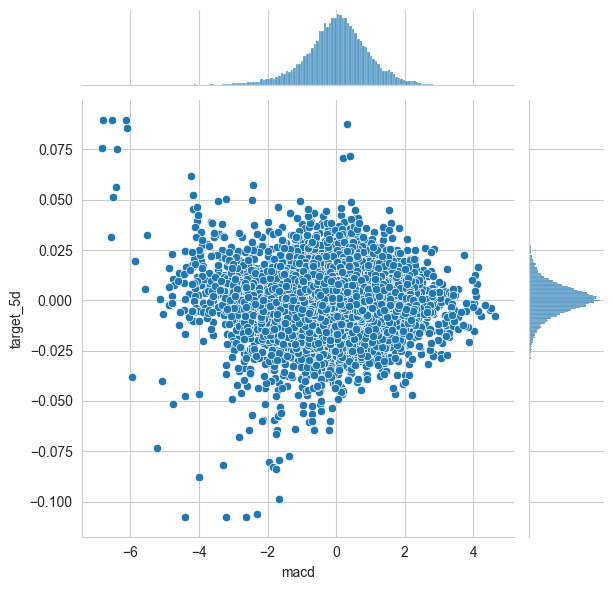

In [55]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')